<a href="https://colab.research.google.com/github/gtbook/gtsam-examples/blob/main/PlanarSLAMExample_gvi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational Bayes Inference

GTSAM is most-often used for posteriori (MAP) estimation, and with the `gtsam.Marginals` object we can get the Laplace approximation to the posterior density. As shown in a [2020 IJRR paper by Tim Barfoot et al](https://journals.sagepub.com/doi/abs/10.1177/0278364920937608), variational Bayes not only optimizes for the mean $\mu$ but also for the covariance $\Sigma$ of an approximation 

$$
q(x) \sim \mathcal{N}(x;\mu, \Sigma).
$$

The key is that we need to take expectations of the factor log-likelihoods with respect to $q(x)$, and a simple way to do this is to *sample* from $q$. The recipe we follow below is then:

- initialize $q(x)$ with MAP and Laplace approximation.
- for a few times:
  - sample from q
  - create linearized factors using the q samples
  - optimize this graph

Note that we sample from $q$, not the true posterior, which would be much harder. In the version below, which uses ancestral sampling to create the expectations, we do not need the marginals of Q explicitly, even though we do compute them in various places to draw covariance ellipses for visualization purposes.

In [1]:
%pip -q install gtbook # also installs latest gtsam pre-release

Note: you may need to restart the kernel to use updated packages.


In [2]:
import math
from math import pi, sqrt
import matplotlib.pyplot as plt
import numpy as np

import gtsam
import gtsam.utils.plot as gtsam_plot
from gtbook.display import show
from gtbook.display import pretty
from gtbook.gaussian import sample_bayes_net
from gtsam import Point2, Pose2, Rot2, noiseModel

# Some keys we use below:
x1, x2, x3 = [gtsam.symbol('x', i) for i in [1, 2, 3]]
l1, l2 = [gtsam.symbol('l', j) for j in [1, 2]]

## Sampling on the Manifold

`sample_bayes_net` creates samples in the *tangent space*, which we then need to upgrade to the non-linear manifold:

In [3]:
def perturb(tangent_samples:dict, values:gtsam.Values, s:int, delta:None):
    vv = gtsam.VectorValues()
    for key in tangent_samples.keys():
        vv.insert(key, tangent_samples[key][:, s])
    return values.retract(vv)  if delta is None else values.retract(vv.add(delta)) 

## A Simple Nonlinear Smoother Example

With the preliminaries out of the way, let us illustrate/sanity-check the GVI scheme with a simple Nonlinear smoother, having only two between constraints on `Pose2` variables.

We first create the `gtsam.NonlinearFactorGraph`:

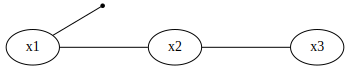

In [4]:
graph = gtsam.NonlinearFactorGraph()
priorMean = Pose2(0.0, 0.0, 0.0)  # prior at origin
priorNoise = noiseModel.Diagonal.Sigmas([0.1, 0.1, math.radians(1)])
graph.add(gtsam.PriorFactorPose2(x1, priorMean, priorNoise))  # add directly to graph
odometry = Pose2(2.0, 0.0, 0.0)
odometryNoise = noiseModel.Diagonal.Sigmas([0.5, 0.2, math.radians(2)])
graph.add(gtsam.BetweenFactorPose2(x1, x2, odometry, odometryNoise))
graph.add(gtsam.BetweenFactorPose2(x2, x3, odometry, odometryNoise))

# Values with ground truth
truth = gtsam.Values()
truth.insert(x1, Pose2(0, 0, 0))
truth.insert(x2, Pose2(2, 0, 0))
truth.insert(x3, Pose2(4, 0, 0))

show(graph, truth, binary_edges=True)


As always, we can calculate and plot covariance ellipses which show the Laplace approximation graphically.

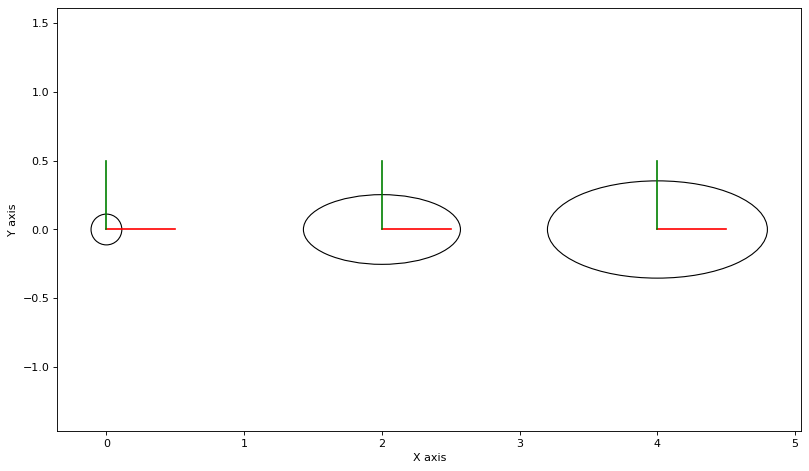

In [5]:
marginals = gtsam.Marginals(graph, truth)
def make_figure():
    plt.figure(0, figsize=(12, 7), dpi=80)
    for key in [x1, x2, x3]:
        gtsam_plot.plot_pose2(0, truth.atPose2(key), 0.5,
                            marginals.marginalCovariance(key))

    plt.axis('equal')

make_figure()

We can also inspect the actual information matrix and covariance matrix, to ascertain sparsity:

In [6]:
def printPQ(bayes_net: gtsam.GaussianBayesNet, N:int=1):
    """Print mean, Hessian, and covariance, possibly with correction factor N"""
    R, d = bayes_net.matrix()
    Q = (R.T @ R)/N  # Hessian/Information matrix
    display(bayes_net.optimize())
    print(f"Q sparsity:\n{(Q>1e-9).astype(int)}")
    print(f"P:\n{np.round(np.linalg.inv(Q),3)}")

printPQ(graph.linearize(truth).eliminateSequential())

Variable,value
x1,0 0 0
x2,0 0 0
x3,0 0 0


Q sparsity:
[[1 0 0 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0]
 [0 1 1 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 1 1 0 0 0]
 [0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 1]]
P:
[[ 0.01   0.     0.     0.01   0.     0.     0.01   0.     0.   ]
 [ 0.     0.01   0.     0.     0.01  -0.     0.     0.01  -0.   ]
 [ 0.    -0.     0.     0.     0.001  0.     0.     0.001  0.   ]
 [ 0.01   0.     0.     0.26   0.     0.     0.26   0.     0.   ]
 [ 0.     0.01   0.001  0.     0.051  0.001  0.     0.052  0.001]
 [ 0.    -0.     0.     0.     0.001  0.002  0.     0.004  0.002]
 [ 0.01   0.     0.     0.26   0.     0.     0.51   0.     0.   ]
 [-0.     0.01   0.001 -0.     0.052  0.004 -0.     0.1    0.004]
 [ 0.    -0.     0.     0.     0.001  0.002  0.     0.004  0.003]]


## Variational Bayes

The code below then uses this sampler to create samples on the product manifold, each sample yielding linearized factors at the sample, yielding a new Gaussian factor graph which has $N$ times as many factors. We then optimize that graph and iterate:

it 1, norm of delta: 0.0105
it 2, norm of delta: 0.0102
it 3, norm of delta: 0.0020
it 4, norm of delta: 0.0006
it 5, norm of delta: 0.0035


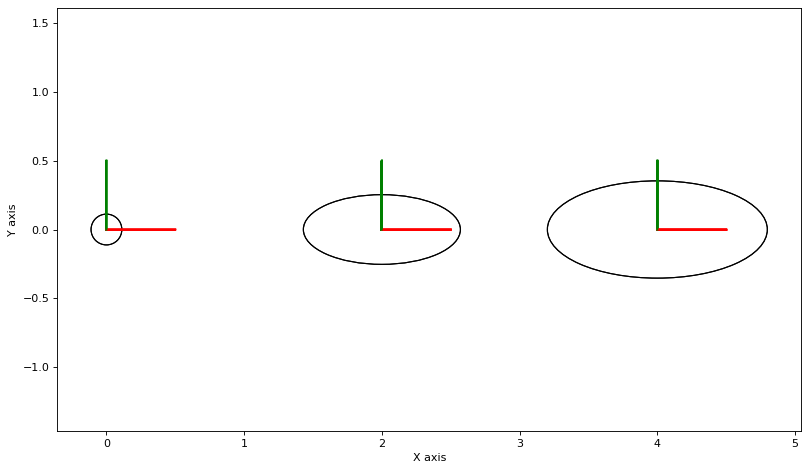

In [7]:
N = 1000

# Start with ground truth
values = gtsam.Values()
values.insert(x1, Pose2(0, 0, 0))
values.insert(x2, Pose2(2, 0, 0))
values.insert(x3, Pose2(4, 0, 0))

big_graph = graph.linearize(values)  # first time it's small!
bayes_net = big_graph.eliminateSequential()
delta = bayes_net.optimize()

make_figure()

for it in range(5):
    # Use the Bayes net to sample from q:
    # KEY STEP: subtract delta from Gaussian samples as we moved to new tangent space
    tangent_samples = sample_bayes_net(bayes_net, N)
    mean_correction = delta.scale(-1)
    manifold_samples = [
        perturb(tangent_samples, values, s, mean_correction) for s in range(N)]

    # Add new linearized factors for every sample:
    big_graph = gtsam.GaussianFactorGraph()
    for manifold_sample in manifold_samples:
        # KEY STEP: factors are duplicated, linearized at manifold_sample
        # TODO: *technically* these are at different tangent spaces
        sample_graph = graph.linearize(manifold_sample)
        big_graph.push_back(sample_graph)

    # Solve by calculating Bayes net and solve.
    # KEY STEP: this forms all Barfoot's expected quantities
    bayes_net = big_graph.eliminateSequential()
    delta = bayes_net.optimize()
    print(f"it {it+1}, norm of delta: {np.linalg.norm(delta.vector()):0.4f}")
    # display(delta)
    # printPQ(bayes_net)

    # update non-linear estimate
    values = values.retract(delta)
    for key in [x1, x2, x3]:
        gtsam_plot.plot_pose2(0, values.atPose2(key), 0.5)

# show new covariances
new_marginals = gtsam.Marginals(big_graph, values)
for key in [x1, x2, x3]:
    gtsam_plot.plot_pose2(0, values.atPose2(key), 0.5,
                          N*new_marginals.marginalCovariance(key))


This is not converging.

## Setting up a non-linear SLAM Example

Below we re-create a similar factor graph as in `PlanarSLAMExample`, but with highly nonlinear measurements on the landmarks. Take a look at the sampling example to appreciate how non-Gaussian the posteriors are in this example.

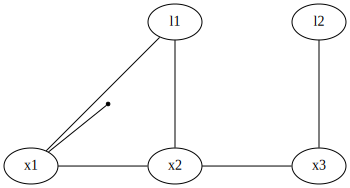

In [8]:
graph = gtsam.NonlinearFactorGraph()
priorMean = Pose2(0.0, 0.0, 0.0)  # prior at origin
priorNoise = noiseModel.Diagonal.Sigmas([0.01, 0.01, math.radians(1)])
graph.add(gtsam.PriorFactorPose2(x1, priorMean, priorNoise))  # add directly to graph
odometry = Pose2(2.0, 0.0, 0.0)
odometryNoise = noiseModel.Diagonal.Sigmas([0.05, 0.02, math.radians(2)])
graph.add(gtsam.BetweenFactorPose2(x1, x2, odometry, odometryNoise))
graph.add(gtsam.BetweenFactorPose2(x2, x3, odometry, odometryNoise))

# Except, we use bearing only measurements for l1
bearingModel = noiseModel.Diagonal.Sigmas([0.1])
graph.add(gtsam.BearingFactor2D(x1, l1, Rot2(math.radians(45)), bearingModel))
graph.add(gtsam.BearingFactor2D(x2, l1, Rot2(math.radians(90)), bearingModel))

brNoise = noiseModel.Diagonal.Sigmas([math.radians(25), 0.1])
graph.add(gtsam.BearingRangeFactor2D(x3, l2, Rot2(math.radians(90)), 2, brNoise))

# Values with ground truth
truth = gtsam.Values()
truth.insert(x1, Pose2(0, 0, 0))
truth.insert(x2, Pose2(2, 0, 0))
truth.insert(x3, Pose2(4, 0, 0))
truth.insert(l1, Point2(2, 2))
truth.insert(l2, Point2(4, 2))

show(graph, truth, binary_edges=True)

As always, we can calculate and plot covariance ellipses which show the Laplace approximation graphically.

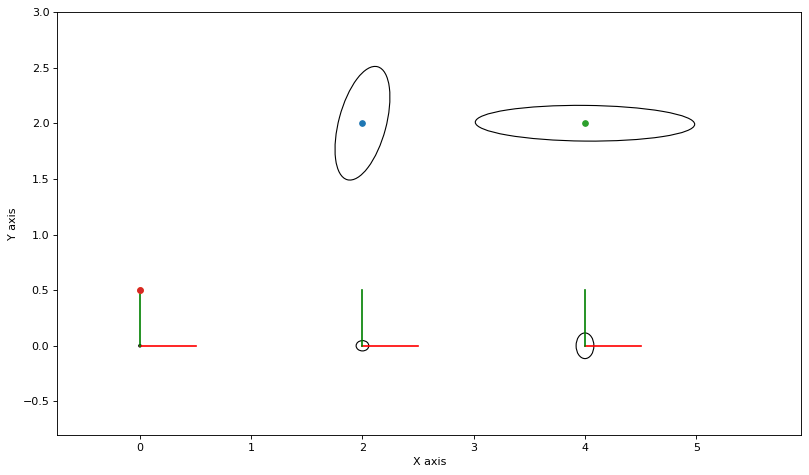

In [9]:
marginals = gtsam.Marginals(graph, truth)
def make_figure():
    plt.figure(0, figsize=(12, 7), dpi=80)
    for key in [x1, x2, x3]:
        gtsam_plot.plot_pose2(0, truth.atPose2(key), 0.5,
                            marginals.marginalCovariance(key))
    for key in [l1, l2]:
        gtsam_plot.plot_point2(0, truth.atPoint2(key), 0.5,
                            marginals.marginalCovariance(key))

    plt.axis('equal')
    plt.xlim([-0.8, 6])
    plt.ylim([-0.8, 3])

make_figure()

## Variational Bayes

The code below then uses this sampler to create samples on the product manifold, each sample yielding linearized factors at the sample, yielding a new Gaussian factor graph which has $N$ times as many factors. We then optimize that graph and iterate:

it 1, norm of delta: 0.1884
it 2, norm of delta: 0.1269
it 3, norm of delta: 0.0319
it 4, norm of delta: 0.0192
it 5, norm of delta: 0.0132
it 6, norm of delta: 0.0093
it 7, norm of delta: 0.0065
it 8, norm of delta: 0.0045
it 9, norm of delta: 0.0033
it 10, norm of delta: 0.0023


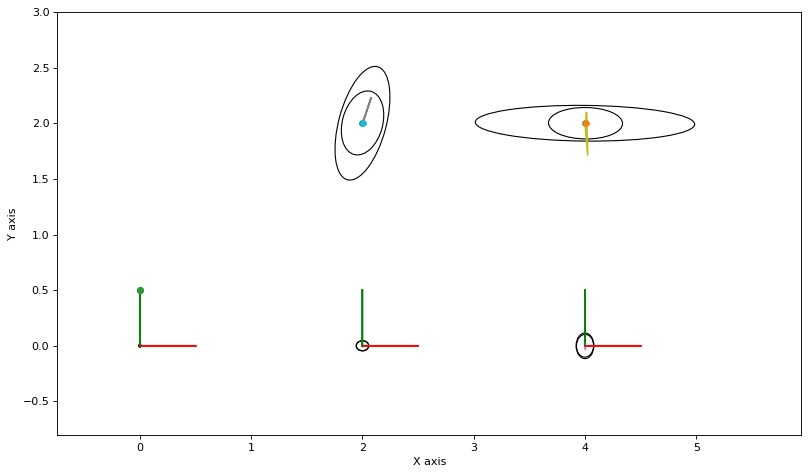

In [10]:
N = 1000

# Start with ground truth
values = gtsam.Values()
values.insert(x1, Pose2(0, 0, 0))
values.insert(x2, Pose2(2, 0, 0))
values.insert(x3, Pose2(4, 0, 0))
values.insert(l1, Point2(2, 2))
values.insert(l2, Point2(4, 2))

big_graph = graph.linearize(values)  # first time it's small!
bayes_net = big_graph.eliminateSequential()
delta = bayes_net.optimize()

make_figure()
evolution = {x1: [gtsam.Point2(0, 0)], x2: [gtsam.Point2(2, 0)], x3: [
    gtsam.Point2(4, 0)], l1: [gtsam.Point2(2, 2)], l2: [gtsam.Point2(4, 2)]}

for it in range(10):
    # Use the Bayes net to sample from q:
    tangent_samples = sample_bayes_net(bayes_net, N)
    mean_correction = delta.scale(-1)
    manifold_samples = [perturb(tangent_samples, values, s, mean_correction) for s in range(N)]

    # Add new linearized factors for every sample:
    big_graph = gtsam.GaussianFactorGraph()
    for manifold_sample in manifold_samples:
        sample_graph = graph.linearize(manifold_sample)
        big_graph.push_back(sample_graph)

    # # Add Levenberg-Marquardt-style prior on delta
    if True:
        _lambda = 0.01
        for key in [x1, x2, x3]:
            big_graph.add(gtsam.JacobianFactor(key, np.eye(3), np.zeros((3,)), 
                noiseModel.Isotropic.Sigma(3, _lambda)))
        for key in [l1, l2]:
            big_graph.add(gtsam.JacobianFactor(key, np.eye(2), np.zeros((2,)), 
                noiseModel.Isotropic.Sigma(2, _lambda)))

    # Solve by calculating Bayes net and solving:
    bayes_net = big_graph.eliminateSequential()
    delta = bayes_net.optimize()
    print(f"it {it+1}, norm of delta: {np.linalg.norm(delta.vector()):.4f}")
    # display(delta)
    # printPQ(bayes_net)

    # update non-linear estimate
    values = values.retract(delta)

    # Record evolution
    iterate = values.retract(delta)
    for key in [x1, x2, x3]:
        evolution[key].append(iterate.atPose2(key).translation())
    for key in [l1, l2]:
        evolution[key].append(iterate.atPoint2(key))

# show evolution:
for key in [x1, x2, x3, l1, l2]:
    points = np.array(evolution[key]).T
    plt.plot(points[0], points[1])

# update non-linear estimate
final = values.retract(delta)

# show new covariances
new_marginals = gtsam.Marginals(big_graph, final)
for key in [x1, x2, x3]:
    gtsam_plot.plot_pose2(0, final.atPose2(key), 0.5,
                        N*new_marginals.marginalCovariance(key))
for key in [l1, l2]:
    gtsam_plot.plot_point2(0, final.atPoint2(key), 0.5,
                        N*new_marginals.marginalCovariance(key))

plt.show()
